In [1]:
# 라이브러리 불러오기
'''메인 라이브러리'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime

'''시각화 관련 라이브러리'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import Grid

%matplotlib inline

'''데이터 준비 및 모델 평가 관련 라이브러리'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from keras.utils import to_categorical

'''알고리즘 관련 라이브러리'''
import lightgbm as lgb

'''텐서플로 및 케라스 관련 라이브러리'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import LeakyReLU, Reshape, UpSampling2D, Conv2DTranspose
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adam, RMSprop
from tensorflow.examples.tutorials.mnist import input_data

Using TensorFlow backend.


In [2]:
# 데이터 로드
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'mnist_data', 'mnist.pkl.gz'])
f = gzip.open(current_path+file, 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [3]:
X_train_keras = X_train.reshape(50000,28,28,1)
X_validation_keras = X_validation.reshape(10000,28,28,1)
X_test_keras = X_test.reshape(10000,28,28,1)

y_train_keras = to_categorical(y_train)
y_validation_keras = to_categorical(y_validation)
y_test_keras = to_categorical(y_test)

In [4]:
# 데이터 셋으로부터 판다스 데이터 프레임 만들기
train_index = range(0,len(X_train))
validation_index = range(len(X_train),len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation),len(X_train)+ \
                   len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

In [5]:
def view_digit(X, y, example):
    label = y.loc[example]
    image = X.loc[example,:].values.reshape([28,28])
    plt.title('Example: %d  Label: %d' % (example, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

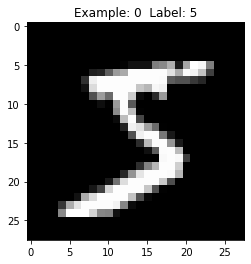

In [6]:
# 첫번째 숫자 이미지 보기
view_digit(X_train, y_train, 0)

In [7]:
# GPU 사용 확인
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else: print("Please install GPU version of TF")

Please install GPU version of TF


In [8]:
# 컨볼루션 신경망(CNN)

In [9]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
# CNN 훈련
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

cnn_history = model.fit(X_train_keras, y_train_keras, 
          validation_data=(X_validation_keras, y_validation_keras), \
          epochs=100)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 164s 3ms/step - loss: 0.1894 - acc: 0.9404 - val_loss: 0.0533 - val_acc: 0.9850
Epoch 2/100
50000/50000 [==============================] - 166s 3ms/step - loss: 0.0733 - acc: 0.9777 - val_loss: 0.0338 - val_acc: 0.9888
Epoch 3/100
50000/50000 [==============================] - 166s 3ms/step - loss: 0.0529 - acc: 0.9848 - val_loss: 0.0328 - val_acc: 0.9903
Epoch 4/100
50000/50000 [==============================] - 177s 4ms/step - loss: 0.0461 - acc: 0.9861 - val_loss: 0.0327 - val_acc: 0.9923
Epoch 5/100
50000/50000 [==============================] - 174s 3ms/step - loss: 0.0395 - acc: 0.9877 - val_loss: 0.0359 - val_acc: 0.9906
Epoch 6/100
50000/50000 [==============================] - 183s 4ms/step - loss: 0.0352 - acc: 0.9888 - val_loss: 0.0334 - val_acc: 0.9926
Epoch 7/100
50000/50

In [11]:
print(cnn_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


CNN Final Accuracy 0.99466


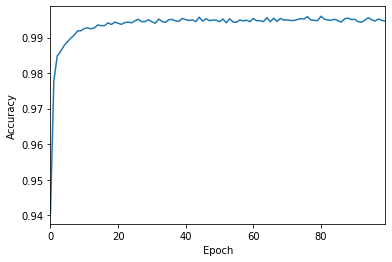

In [12]:
## CNN 정확도 그래프
print("CNN Final Accuracy", cnn_history.history['acc'][-1])
pd.Series(cnn_history.history['acc']).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [13]:
# DCGAN

In [14]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time))

class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # 감별자
        self.G = None   # 생성자
        self.AM = None  # 적대 모델
        self.DM = None  # 판별 모델
        
    def generator(self, depth=256, dim=7, dropout=0.3, momentum=0.8, \
                  window=5, input_dim=100, output_depth=1):
        if self.G:
            return self.G
        self.G = Sequential()
        self.G.add(Dense(dim*dim*depth, input_dim=input_dim))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))
        
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), window, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), window, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(int(depth/8), window, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(output_depth, window, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G

    def discriminator(self, depth=64, dropout=0.3, alpha=0.3):
        if self.D:
            return self.D
        self.D = Sequential()
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,
            padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', \
                        optimizer=optimizer, metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', \
                        optimizer=optimizer, metrics=['accuracy'])
        return self.AM
        
class MNIST_DCGAN(object):
    def __init__(self, x_train):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1

        self.x_train = x_train

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0,
                self.x_train.shape[0], size=batch_size), :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], \
                                                      a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, \
                        samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=16, \
                    noise=None, step=0):
        current_path = os.getcwd()
        file = os.path.sep.join(['', 'images', 'chapter12', 'synthetic_mnist', ''])
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(current_path+file+filename)
            plt.close('all')
        else:
            plt.show()

In [15]:
# MNIST DCGAN 초기화 및 훈련
mnist_dcgan = MNIST_DCGAN(X_train_keras)
timer = ElapsedTimer()
mnist_dcgan.train(train_steps=1000, batch_size=256, save_interval=500)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)        

36: [D loss: 1.130640, acc: 0.500000]  [A loss: 5.120434, acc: 0.000000]
37: [D loss: 0.466640, acc: 0.816406]  [A loss: 0.593685, acc: 0.750000]
38: [D loss: 1.012480, acc: 0.498047]  [A loss: 5.111442, acc: 0.000000]
39: [D loss: 0.413751, acc: 0.873047]  [A loss: 0.716864, acc: 0.464844]
40: [D loss: 1.005464, acc: 0.500000]  [A loss: 6.015405, acc: 0.000000]
41: [D loss: 0.460717, acc: 0.785156]  [A loss: 0.345922, acc: 0.992188]
42: [D loss: 1.169728, acc: 0.500000]  [A loss: 5.284122, acc: 0.000000]
43: [D loss: 0.404098, acc: 0.859375]  [A loss: 0.592992, acc: 0.746094]
44: [D loss: 1.076239, acc: 0.500000]  [A loss: 5.559307, acc: 0.000000]
45: [D loss: 0.398750, acc: 0.878906]  [A loss: 0.505917, acc: 0.851562]
46: [D loss: 1.091951, acc: 0.500000]  [A loss: 5.667561, acc: 0.000000]
47: [D loss: 0.381177, acc: 0.859375]  [A loss: 0.559675, acc: 0.769531]
48: [D loss: 1.086157, acc: 0.500000]  [A loss: 5.680429, acc: 0.000000]
49: [D loss: 0.383475, acc: 0.876953]  [A loss: 0.4

148: [D loss: 0.629178, acc: 0.671875]  [A loss: 0.142134, acc: 1.000000]
149: [D loss: 1.391781, acc: 0.500000]  [A loss: 3.813511, acc: 0.000000]
150: [D loss: 0.623599, acc: 0.679688]  [A loss: 0.151918, acc: 1.000000]
151: [D loss: 1.359521, acc: 0.500000]  [A loss: 3.179872, acc: 0.000000]
152: [D loss: 0.550744, acc: 0.730469]  [A loss: 0.415308, acc: 0.890625]
153: [D loss: 1.126185, acc: 0.500000]  [A loss: 4.330553, acc: 0.000000]
154: [D loss: 0.657150, acc: 0.658203]  [A loss: 0.065557, acc: 1.000000]
155: [D loss: 1.661976, acc: 0.500000]  [A loss: 2.225899, acc: 0.000000]
156: [D loss: 0.604967, acc: 0.587891]  [A loss: 1.773468, acc: 0.003906]
157: [D loss: 0.778967, acc: 0.507812]  [A loss: 4.000479, acc: 0.000000]
158: [D loss: 0.583381, acc: 0.666016]  [A loss: 0.354892, acc: 0.949219]
159: [D loss: 1.230137, acc: 0.500000]  [A loss: 5.825819, acc: 0.000000]
160: [D loss: 0.953789, acc: 0.546875]  [A loss: 0.013041, acc: 1.000000]
161: [D loss: 2.402236, acc: 0.500000]

259: [D loss: 0.870947, acc: 0.519531]  [A loss: 4.403214, acc: 0.000000]
260: [D loss: 0.677291, acc: 0.603516]  [A loss: 0.901927, acc: 0.414062]
261: [D loss: 1.370507, acc: 0.496094]  [A loss: 8.237375, acc: 0.000000]
262: [D loss: 1.299264, acc: 0.519531]  [A loss: 0.008255, acc: 1.000000]
263: [D loss: 3.255571, acc: 0.500000]  [A loss: 1.268170, acc: 0.132812]
264: [D loss: 1.058719, acc: 0.515625]  [A loss: 4.212512, acc: 0.000000]
265: [D loss: 0.667143, acc: 0.609375]  [A loss: 0.593218, acc: 0.664062]
266: [D loss: 1.255504, acc: 0.503906]  [A loss: 5.090504, acc: 0.000000]
267: [D loss: 0.701051, acc: 0.607422]  [A loss: 0.203607, acc: 0.964844]
268: [D loss: 1.487876, acc: 0.498047]  [A loss: 4.883289, acc: 0.000000]
269: [D loss: 0.739297, acc: 0.587891]  [A loss: 0.131439, acc: 1.000000]
270: [D loss: 1.491327, acc: 0.500000]  [A loss: 4.197680, acc: 0.000000]
271: [D loss: 0.661066, acc: 0.630859]  [A loss: 0.508325, acc: 0.746094]
272: [D loss: 1.227783, acc: 0.500000]

370: [D loss: 1.468884, acc: 0.507812]  [A loss: 8.942386, acc: 0.000000]
371: [D loss: 1.295164, acc: 0.542969]  [A loss: 0.004960, acc: 1.000000]
372: [D loss: 4.106701, acc: 0.500000]  [A loss: 1.874595, acc: 0.054688]
373: [D loss: 1.414032, acc: 0.529297]  [A loss: 5.848364, acc: 0.000000]
374: [D loss: 0.679717, acc: 0.628906]  [A loss: 0.414316, acc: 0.800781]
375: [D loss: 1.595871, acc: 0.503906]  [A loss: 6.791341, acc: 0.000000]
376: [D loss: 0.801455, acc: 0.599609]  [A loss: 0.082034, acc: 0.996094]
377: [D loss: 2.097315, acc: 0.503906]  [A loss: 5.127953, acc: 0.000000]
378: [D loss: 0.708479, acc: 0.601562]  [A loss: 0.843938, acc: 0.488281]
379: [D loss: 1.552530, acc: 0.501953]  [A loss: 7.213005, acc: 0.000000]
380: [D loss: 0.823337, acc: 0.619141]  [A loss: 0.028600, acc: 1.000000]
381: [D loss: 2.565025, acc: 0.500000]  [A loss: 4.603961, acc: 0.000000]
382: [D loss: 0.698648, acc: 0.603516]  [A loss: 2.226964, acc: 0.023438]
383: [D loss: 1.394021, acc: 0.513672]

481: [D loss: 1.168378, acc: 0.546875]  [A loss: 0.007435, acc: 1.000000]
482: [D loss: 4.019090, acc: 0.500000]  [A loss: 3.822124, acc: 0.003906]
483: [D loss: 1.051565, acc: 0.554688]  [A loss: 6.287003, acc: 0.000000]
484: [D loss: 0.750531, acc: 0.593750]  [A loss: 0.595524, acc: 0.683594]
485: [D loss: 1.692777, acc: 0.501953]  [A loss: 9.322035, acc: 0.000000]
486: [D loss: 1.317003, acc: 0.550781]  [A loss: 0.005195, acc: 1.000000]
487: [D loss: 4.208699, acc: 0.500000]  [A loss: 3.454854, acc: 0.015625]
488: [D loss: 1.316647, acc: 0.529297]  [A loss: 6.769234, acc: 0.000000]
489: [D loss: 0.788510, acc: 0.582031]  [A loss: 1.027893, acc: 0.375000]
490: [D loss: 1.912511, acc: 0.498047]  [A loss: 9.033949, acc: 0.000000]
491: [D loss: 1.238500, acc: 0.539062]  [A loss: 0.004582, acc: 1.000000]
492: [D loss: 4.106145, acc: 0.500000]  [A loss: 3.605864, acc: 0.003906]
493: [D loss: 1.365711, acc: 0.527344]  [A loss: 7.387376, acc: 0.000000]
494: [D loss: 0.774306, acc: 0.615234]

592: [D loss: 4.042895, acc: 0.500000]  [A loss: 5.484823, acc: 0.000000]
593: [D loss: 1.021010, acc: 0.523438]  [A loss: 4.784222, acc: 0.000000]
594: [D loss: 1.303513, acc: 0.500000]  [A loss: 8.006723, acc: 0.000000]
595: [D loss: 0.871951, acc: 0.593750]  [A loss: 0.137677, acc: 0.945312]
596: [D loss: 2.302159, acc: 0.509766]  [A loss: 9.848890, acc: 0.000000]
597: [D loss: 1.225886, acc: 0.537109]  [A loss: 0.007611, acc: 1.000000]
598: [D loss: 3.648648, acc: 0.500000]  [A loss: 5.283553, acc: 0.000000]
599: [D loss: 0.946318, acc: 0.564453]  [A loss: 5.676041, acc: 0.000000]
600: [D loss: 0.977860, acc: 0.566406]  [A loss: 5.867281, acc: 0.000000]
601: [D loss: 1.006917, acc: 0.523438]  [A loss: 5.984317, acc: 0.000000]
602: [D loss: 1.057338, acc: 0.556641]  [A loss: 6.200035, acc: 0.000000]
603: [D loss: 1.085588, acc: 0.535156]  [A loss: 7.970175, acc: 0.000000]
604: [D loss: 0.983300, acc: 0.533203]  [A loss: 1.049197, acc: 0.460938]
605: [D loss: 2.153307, acc: 0.505859]

703: [D loss: 1.929061, acc: 0.511719]  [A loss: 10.269342, acc: 0.000000]
704: [D loss: 1.215729, acc: 0.558594]  [A loss: 0.007983, acc: 1.000000]
705: [D loss: 4.536678, acc: 0.500000]  [A loss: 6.194008, acc: 0.000000]
706: [D loss: 1.101581, acc: 0.576172]  [A loss: 7.066760, acc: 0.000000]
707: [D loss: 0.869638, acc: 0.582031]  [A loss: 3.475508, acc: 0.011719]
708: [D loss: 2.047473, acc: 0.511719]  [A loss: 12.709700, acc: 0.000000]
709: [D loss: 2.607450, acc: 0.513672]  [A loss: 0.001786, acc: 1.000000]
710: [D loss: 6.159762, acc: 0.500000]  [A loss: 0.697981, acc: 0.675781]
711: [D loss: 2.236936, acc: 0.517578]  [A loss: 10.314039, acc: 0.000000]
712: [D loss: 0.911367, acc: 0.603516]  [A loss: 0.469625, acc: 0.765625]
713: [D loss: 2.125816, acc: 0.507812]  [A loss: 11.094021, acc: 0.000000]
714: [D loss: 1.212066, acc: 0.582031]  [A loss: 0.007683, acc: 1.000000]
715: [D loss: 4.106013, acc: 0.500000]  [A loss: 4.350306, acc: 0.000000]
716: [D loss: 1.445452, acc: 0.546

814: [D loss: 2.326491, acc: 0.513672]  [A loss: 0.001070, acc: 1.000000]
815: [D loss: 6.062399, acc: 0.500000]  [A loss: 0.924136, acc: 0.546875]
816: [D loss: 2.557844, acc: 0.507812]  [A loss: 10.790518, acc: 0.000000]
817: [D loss: 1.023844, acc: 0.544922]  [A loss: 1.203753, acc: 0.460938]
818: [D loss: 2.707287, acc: 0.505859]  [A loss: 12.423460, acc: 0.000000]
819: [D loss: 1.882139, acc: 0.519531]  [A loss: 0.002670, acc: 1.000000]
820: [D loss: 5.492286, acc: 0.500000]  [A loss: 2.720038, acc: 0.160156]
821: [D loss: 2.970702, acc: 0.503906]  [A loss: 11.238516, acc: 0.000000]
822: [D loss: 1.074692, acc: 0.544922]  [A loss: 0.436639, acc: 0.761719]
823: [D loss: 2.624240, acc: 0.500000]  [A loss: 11.987561, acc: 0.000000]
824: [D loss: 1.418047, acc: 0.527344]  [A loss: 0.013313, acc: 0.996094]
825: [D loss: 4.094807, acc: 0.500000]  [A loss: 7.888514, acc: 0.000000]
826: [D loss: 1.297011, acc: 0.556641]  [A loss: 7.559012, acc: 0.000000]
827: [D loss: 1.139726, acc: 0.593

925: [D loss: 2.969105, acc: 0.509766]  [A loss: 11.953415, acc: 0.000000]
926: [D loss: 1.062994, acc: 0.595703]  [A loss: 0.022952, acc: 0.996094]
927: [D loss: 3.728868, acc: 0.501953]  [A loss: 8.910909, acc: 0.000000]
928: [D loss: 1.111070, acc: 0.589844]  [A loss: 4.896560, acc: 0.011719]
929: [D loss: 2.490287, acc: 0.517578]  [A loss: 13.624281, acc: 0.000000]
930: [D loss: 2.972555, acc: 0.498047]  [A loss: 0.000590, acc: 1.000000]
931: [D loss: 6.271840, acc: 0.500000]  [A loss: 0.528188, acc: 0.726562]
932: [D loss: 2.918244, acc: 0.509766]  [A loss: 11.447428, acc: 0.000000]
933: [D loss: 1.156206, acc: 0.550781]  [A loss: 0.672046, acc: 0.652344]
934: [D loss: 2.631336, acc: 0.509766]  [A loss: 12.324687, acc: 0.000000]
935: [D loss: 1.395727, acc: 0.562500]  [A loss: 0.016604, acc: 0.996094]
936: [D loss: 4.143648, acc: 0.500000]  [A loss: 7.410161, acc: 0.000000]
937: [D loss: 1.808174, acc: 0.546875]  [A loss: 10.880534, acc: 0.000000]
938: [D loss: 1.066182, acc: 0.56

Elapsed: 4.34897359960609 hr 


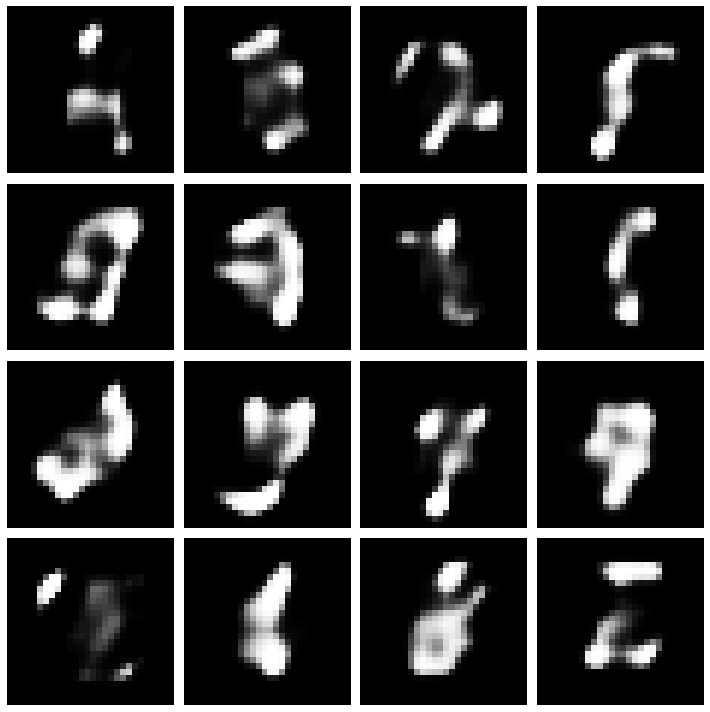

In [16]:
# 합성 MNIST 이미지 배치 생성
timer.elapsed_time()
mnist_dcgan.plot_images(fake=True)
mnist_dcgan.plot_images(fake=False, save2file=True)